### Import required libraries

In [2]:

import pymysql
from cryptography.fernet import Fernet
import json
from collections import namedtuple
import time
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine 
from sklearn import model_selection
from sklearn.metrics import classification_report as cr
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances

%matplotlib inline

### Increase the size of the screen

In [3]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Decrypt Credentials and Connect to Database

In [4]:
#Uncode the secret license file
def unencrypt():
    try:
        key = b'IXx5rHfP15FqP4ahx2pwcud-XmcBzU553Ri6p-nVhnc=' #Fernet.generate_key()
        cipher_suite = Fernet(key)
        with open('/usr/local/etc/musicmood_bytes.bin', 'rb') as file_object:
            for line in file_object:
                encryptedpwd = line
        uncipher_text = (cipher_suite.decrypt(encryptedpwd))
        plain_text_encryptedpassword = bytes(uncipher_text).decode("utf-8") #convert to string
        x = json.loads(plain_text_encryptedpassword, object_hook=lambda d: namedtuple('X', d.keys())(*d.values()))
        return x
    except Exception as e:
        print(str(e))
        return "Error" 

#Setup the database connection
credentials = unencrypt()
user_id = credentials.user
user_password = credentials.password
dbname = credentials.dbname
server = credentials.server
conn = pymysql.connect(server,user_id,user_password,dbname)

### Load the clean dataset

In [5]:
start_time = time.time()
df = pd.read_sql('SELECT * FROM songs_instances_data', con = conn)
print('--- %s seconds ---' % (time.time() - start_time))
    
df.drop(['index'],axis=1, inplace=True)
df.head(15)

df.describe()
#print(df.columns)

--- 1.1112439632415771 seconds ---


,bill_popularity,weeks_ranked,highest_rank,lowest_rank,weeks_top_spot,weeks_top_10,weeks_top_20,weeks_top_30,weeks_top_40,weeks_top_50,average_rank,year_first_appear,year_last_appear,decade,duration,key_song,loudness,mode,tempo,time_signature,number_1s,weeks_at_number_1,chart_appearances,speed_general,artist_familiarity,artist_hotttnesss,year_added,words_song_u,words_song,words_song_r,words_genre_u,words_genre,words_genre_r,words_second,gnr_Blues,gnr_Country,gnr_Folk,gnr_Funk,gnr_House Electronic Trance,gnr_Jazz,gnr_Latin,gnr_Metal,gnr_Pop,gnr_Pop Standards,gnr_Punk,gnr_Rap Hip Hop,gnr_Rhythm and Blues,gnr_Rock,gnr_Rock and Roll,gnr_Ska Reggae Dancehall,is_top40
count,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000,12255.000000
mean,461.917585,8.590371,24.106161,57.427989,0.112444,1.080294,2.104774,3.076295,3.985149,4.848960,35.648552,1281.211261,1281.411832,1982.074255,237.804162,5.315300,-9.215717,0.709914,124.189140,3.626030,0.535537,1.478907,101.982864,2.495390,0.670480,0.479963,1986.581722,86.935599,259.026551,0.364790,87.425214,259.429376,0.341456,1.415320,0.006691,0.067646,0.026275,0.000326,0.029621,0.022358,0.006528,0.067156,0.137087,0.019502,0.002285,0.045777,0.049857,0.368666,0.031089,0.002856,0.379111
std,646.707813,9.515133,29.813271,43.503135,1.002081,3.229548,4.882840,6.084759,7.014856,7.747965,32.429124,947.655524,947.804741,15.057890,90.091553,3.588874,3.902081,0.453820,31.397375,1.114364,1.551580,5.153640,144.954553,0.561065,0.124608,0.116631,15.131608,34.186147,124.808211,0.112119,21.491572,73.601847,0.035276,0.375069,0.081529,0.251147,0.159958,0.018064,0.169545,0.147852,0.080535,0.250303,0.343953,0.138288,0.047747,0.209010,0.217659,0.482463,0.173566,0.053367,0.485185
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1950.000000,2.000000,0.000000,-37.695999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1956.000000,1.000000,1.000000,0.040000,67.000000,172.000000,0.260000,0.302600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1970.000000,181.000000,2.000000,-11.644000,0.000000,100.880500,4.000000,0.000000,0.000000,0.000000,2.000000,0.589133,0.400982,1973.000000,69.000000,185.000000,0.300000,80.000000,229.000000,0.310000,1.398200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,167.000000,7.000000,9.000000,82.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.000000,1968.000000,1968.000000,1980.000000,227.000000,5.000000,-8.686000,1.000000,121.603996,4.000000,0.000000,0.000000,38.000000,3.000000,0.671095,0.463155,1987.000000,86.935599,259.000000,0.335624,80.000000,229.000000,0.350000,1.527000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,799.000000,15.000000,44.000000,95.000000,0.000000,0.000000,1.000000,5.000000,7.000000,9.000000,63.000000,1986.000000,1986.000000,2000.000000,272.000000,9.000000,-6.260500,1.000000,141.956000,4.000000,0.000000,0.000000,153.000000,3.00

### Visualize only important features 

In [66]:
songs = df [['duration', 'key_song', 'loudness', 'mode', 'tempo', 'time_signature', 'words_song_u', 'words_song', \
             'words_song_r', 'words_genre_u', 'words_genre', 'words_genre_r', 'words_second', 'speed_general', \
             'artist_familiarity', 'artist_hotttnesss', 'gnr_Blues', 'gnr_Country', 'gnr_Folk', 'gnr_Funk', \
             'gnr_House Electronic Trance', 'gnr_Jazz', 'gnr_Latin', 'gnr_Metal', 'gnr_Pop', 'gnr_Pop Standards', \
             'gnr_Punk', 'gnr_Rap Hip Hop', 'gnr_Rhythm and Blues', 'gnr_Rock', 'gnr_Rock and Roll', \
             'gnr_Ska Reggae Dancehall', 'is_top40']]
songs.shape

(12255, 33)

### Correlation Matrix Plot

In [ ]:
import seaborn as sns
corr = songs.corr()
fig, ax = plt.subplots(figsize=(25,15)) 
ax=sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, linewidths=.5, cmap="Greens")
plt.show()

### Scatterplot

In [ ]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
g = sns.pairplot(songs, size=3, hue='is_top40', vars=['duration', 'key_song', 'loudness', 'mode', 'tempo', \
                                      'time_signature','is_top40'], kind="reg")

In [ ]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
g = sns.pairplot(songs, size=3, hue='is_top40', vars=['words_song_u','words_song', 'words_song_r', 'words_genre_u','words_genre',\
                                      'words_genre_r','words_second','is_top40'], kind="reg")

In [ ]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
g = sns.pairplot(songs,hue='is_top40', size=3, vars=['speed_general', 'artist_familiarity', 'artist_hotttnesss', \
            'gnr_Metal','is_top40'], kind="reg")

### Scatter Matrix

In [ ]:
# Create a scatter matrix of the dataframe features
from pandas.plotting import scatter_matrix
scatter_matrix(songs, alpha=0.5, figsize=(22, 22), diagonal='kde')
plt.show()

### Kernel Density Estimation Plots

In [ ]:
songs.plot(kind='kde', subplots=True, layout=(5,7), sharex=False, sharey=False, figsize=(25,25))
plt.show()

### Box Plots 

In [ ]:
songs.plot(kind='box', subplots=True, layout=(5,7), sharex=False, sharey=False, figsize=(30,30))
plt.show()

### Parallel Coordinates

In [ ]:
from yellowbrick.features import ParallelCoordinates
# features = ['duration', 'key_song', 'loudness', 'mode', 'tempo', 'time_signature', 'words_song_u', \
#             'words_song', 'words_song_r', 'words_genre_u', 'words_genre', 'words_genre_r', 'words_second', 
#             'speed_general', 'artist_familiarity', 'artist_hotttnesss', 'gnr_Metal']
classes = ["Top40", "No Hit"]

features = [ 'gnr_Metal','duration', 'loudness', 'mode', 'tempo', 'words_song','gnr_Rock', 'words_song_r', 'words_genre_u', 'words_genre_r',\
            'words_second',  'gnr_Rock and Roll', 'artist_hotttnesss']
X = songs[features]
y = songs.is_top40
_, ax = plt.subplots(figsize=(20,8))
# Instantiate the visualizer
visualizer = ParallelCoordinates(
    classes=classes, features=features, normalize='minmax',sample=0.5, shuffle=True
)

# Fit and transform the data to the visualizer
visualizer.fit_transform(X, y)

# Finalize the title and axes then display the visualization
visualizer.poof()

### Rad Viz

In [ ]:
# Specify the features of interest and the classes of the target
classes = ["Top40", "NoHit"]
# Extract the numpy arrays from the data frame
X = songs[features].as_matrix()
y = songs.is_top40.as_matrix()
# Import the visualizer
from yellowbrick.features import RadViz

# Instantiate the visualizer
_,ax = plt.subplots(figsize=(20,20))
visualizer = RadViz(classes=classes, features=features)

visualizer.fit(X, y)      # Fit the data to the visualizer
visualizer.transform(X)   # Transform the data
visualizer.poof()         # Draw/show/poof the data

# Initial Model Comparison

### Split-Out validation dataset

In [100]:
array = songs.values
X = array[:,0:-1]
Y = array[:,-1] #is_top40
    
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = \
model_selection.train_test_split(X, Y,test_size=validation_size,stratify = Y, random_state=seed)


  ### Test options and evaluation metric

In [101]:
seed = 7
scoring = 'accuracy'

In [102]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import RadiusNeighborsClassifier

from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.svm import LinearSVC

from sklearn.ensemble import AdaBoostClassifier

### HyperParameter Tuning with GridSearchCV

In [ ]:
from __future__ import print_function

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

print(__doc__)



# Specify the features of interest and the target
target = 'is_top40'
features = [col for col in data.columns if col != target]

# Encode the categorical data with one-hot encoding
X = data[features]
y = data[target]

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
#RandomForest
# tuned_parameters = [{'criterion': ['entropy','gini'], 'n_estimators': [1, 5, 10, 100],
#  'max_depth': [1, 2, 3, 4, 5, 7, 9, 12]},
# {'warm_start': [True, False], 'max_features': ['auto']}]

#LDA
# tuned_parameters = [{'n_components': [None,1, 10, 20, 30], 'tol': [0.0001,0.001,0.01,0.1],
#  'solver': ['svd','lsqr']}]
#QDA
# tuned_parameters = [{'reg_param': [0.001,0.001,0.01,0.1,1.0], 'tol': [0.0001,0.001,0.01,0.1],
#  'store_covariance': [True,False]}]

#Logistic Regression
# tuned_parameters = [{'penalty': ['l2'], 'C': [0.1, 1.0, 1.5, 2.5, 5.0],
#  'random_state': [1,3,5,7,12],'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'tol': [0.0001,0.001,0.01,0.1],},
# {'warm_start': [True, False]}]

#Logistic Regression CV
tuned_parameters = [{'Cs': [1,2,3,4,5], 'cv': [10,12],'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'tol': [0.0001,0.001,0.01,0.1],},
{'refit': [True, False]}]
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


### Selected Algorithms

In [103]:
models = []
# #Naive Bayes,
models.append(('NB', GaussianNB(priors = [0.99,0.01])))
models.append(('BNB', BernoulliNB(alpha = 0.001, binarize = 0.95, class_prior = [0.8,0.2], fit_prior = True)))
# # #Decision Tree,
models.append(('CART',DecisionTreeClassifier(criterion = 'entropy', splitter='random',
                                             max_depth = 10,max_leaf_nodes = 12,
                                             min_impurity_decrease = 0.35, random_state = 7)))
models.append(('RFC', RandomForestClassifier(criterion='gini',n_estimators=100,max_depth=12)))

# Discriminant Analysis,
#{'n_components': None, 'solver': 'lsqr', 'tol': 0.0001},
models.append(('LDA', LinearDiscriminantAnalysis(n_components=10,solver='lsqr',tol=0.0001)))
#{'reg_param': 0.1, 'store_covariance': True, 'tol': 0.0001},
#models.append(('QDA', QuadraticDiscriminantAnalysis(reg_param=0.1,store_covariance=True,tol=0.0001)))
,
# #LogisticRegression,
# {'C': 1.5, 'penalty': 'l2', 'random_state': 1, 'solver': 'newton-cg', 'tol': 0.0001},
models.append(('LRG', LogisticRegression(C=1.5,penalty='l2', random_state=7,solver = 'liblinear', tol = 0.0001, warm_start = True)))
#{'Cs': 2, 'cv': 10, 'solver': 'liblinear', 'tol': 0.1},
models.append(('LCV', LogisticRegressionCV(Cs=2,cv=10,solver='liblinear', tol=0.1, refit=True)))

#KNN,
models.append(('KNN', KNeighborsClassifier()))
models.append(('NCT', NearestCentroid()))
#models.append(('KNN', NearestNeighbors()))
#models.append(('RNC', RadiusNeighborsClassifier(radius=5.0, outlier_label=1)))
#Support Vector Machine,
models.append(('SVM', SVC()))#(kernel='linear', C=0.025))) 
models.append(('NuSVM', NuSVC()))
models.append(('LinearSVC', LinearSVC())) 

models.append(('ABC',AdaBoostClassifier()))

#LogisticRegressionCV().get_params(deep = True),

# alpha_spc = np.linspace(0.0,0.5,num=10, endpoint=True)
# for a in range(len(alpha_spc)):
# models.append(('CART'+str(alpha_spc[a]),DecisionTreeClassifier(criterion = 'entropy', splitter='random', max_depth =10,max_features= 13,
#max_leaf_nodes = 12, min_impurity_split = 0.35, random_state = 7,
#min_weight_fraction_leaf = int(alpha_spc[a]))))
# print(str(alpha_spc[a]))



# KNeighborsClassifier().get_params(deep = True)
# n_neighbors = np.linspace(1,12,num=12, endpoint=True)
# for a in range(len(n_neighbors)):
#     models.append(('KNC'+ str(int(n_neighbors[a])), KNeighborsClassifier(algorithm = 'auto', metric = 'minkowski', n_jobs= -1, n_neighbors= int(n_neighbors[a]))))
    
# print(models)
                                                                       


# import numpy as np
# from yellowbrick.model_selection import ValidationCurve

# pr = np.linspace(1, 5, num=5, endpoint=True)
# print(np.linspace(1, 5, num=5, endpoint=True))
# model = ValidationCurve(KNeighborsClassifier(), param_name="n_neighbors", param_range=pr)
# model.fit(X_train, Y_train)
# model.poof()


In [104]:
RandomForestClassifier().get_params(deep = True)

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Initial Evaluation Each Model in Turn

In [105]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

results = []
names = []

print('\nTest Accuracy with Scaling and PCA\n')
start_time = time.time()
for name, model in models:
    pipe_mdl = make_pipeline(StandardScaler(),
                        PCA(n_components=18),
                        model)
    pipe_mdl.fit(X_train, Y_train)
    y_pred = pipe_mdl.predict(X_validation)
    pipe_results =pipe_mdl.score(X_validation, Y_validation)
    print('%s Test Accuracy: %f' % (name, pipe_results))
print('--- %s seconds ---' % (time.time() - start_time))    
print()


start_time = time.time()
print('\nTest Accuracy with Stratified KFold within Pipeline \n')
# from sklearn.model_selection import StratifiedKFold
# for name, model in models:
#     pipe_mdl = make_pipeline(StandardScaler(),
#                         PCA(n_components=18),
#                         model)
#     kfold = model_selection.StratifiedKFold(n_splits=10, random_state=1).split(X_train,Y_train)
#     scores = []
#     mnames = []
#     for k, (train,test) in enumerate(kfold):
#         pipe_mdl.fit(X_train[train],Y_train[train])
#         score = pipe_mdl.score(X_train[test],Y_train[test])
#         #print('Fold: %2d,  Acc: %.3f' % (k+1,score))
#         scores.append(score)
#         mnames.append(name)
#     print('%s CV accuracy: %.3f +/- %.3f' %(name, np.mean(scores), np.std(scores)))

from sklearn.model_selection import cross_val_score
res_scores = []
m_names = []
for name, model in models:
    print(name)
    pipe_mdl = make_pipeline(StandardScaler(),
                        PCA(n_components=18),
                        model)
    scores = cross_val_score(estimator=pipe_mdl,
                         X=X_train,
                         y=Y_train,
                         cv=12,
                         n_jobs=1)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))
    res_scores.append(scores)
    m_names.append(name)
print('--- %s seconds ---' % (time.time() - start_time))


# print('\nTest Accuracy with KFold Test \n')
# start_time = time.time()
# for name, model in models:    
#     kfold = model_selection.KFold(n_splits=10, random_state=1)
#     cv_results = model_selection.cross_val_score(model, X_validation, Y_validation, cv=kfold, scoring=scoring)
#     results.append(cv_results)
#     names.append(name)
#     msg = '%s: %.3f +/- (%.3f)'% (name, cv_results.mean(), cv_results.std())
#     print(msg)
# print('--- %s seconds ---' % (time.time() - start_time))


Test Accuracy with Scaling and PCA

NB Test Accuracy: 0.644227
BNB Test Accuracy: 0.633619
CART Test Accuracy: 0.620971
RFC Test Accuracy: 0.677683
LDA Test Accuracy: 0.672379
LRG Test Accuracy: 0.668707
LCV Test Accuracy: 0.668299
KNN Test Accuracy: 0.651571
NCT Test Accuracy: 0.616483
SVM Test Accuracy: 0.681763
NuSVM Test Accuracy: 0.663811
LinearSVC Test Accuracy: 0.670747
ABC Test Accuracy: 0.650347
--- 23.996031999588013 seconds ---


Test Accuracy with Stratified KFold within Pipeline 

NB
CV accuracy: 0.638 +/- 0.011
BNB
CV accuracy: 0.633 +/- 0.014
CART
CV accuracy: 0.621 +/- 0.000
RFC
CV accuracy: 0.675 +/- 0.009
LDA
CV accuracy: 0.657 +/- 0.018
LRG
CV accuracy: 0.656 +/- 0.018
LCV
CV accuracy: 0.657 +/- 0.017
KNN
CV accuracy: 0.649 +/- 0.014
NCT
CV accuracy: 0.610 +/- 0.012
SVM
CV accuracy: 0.674 +/- 0.009
NuSVM
CV accuracy: 0.656 +/- 0.013
LinearSVC
CV accuracy: 0.657 +/- 0.017
ABC
CV accuracy: 0.656 +/- 0.015
--- 220.9127118587494 seconds ---


### Compare Algorithms

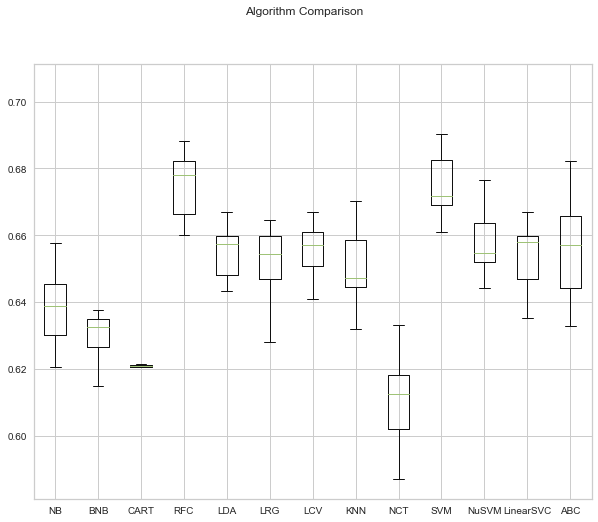

In [106]:
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(res_scores)
ax.set_xticklabels(m_names)
plt.show()

### Applying the Visualization to the Models

NB
0.5630354957160343
[[540 982]
 [ 89 840]]


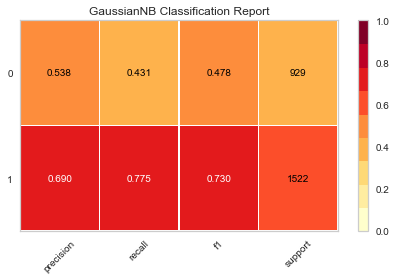

BNB
0.6409628722970216
[[1276  246]
 [ 634  295]]


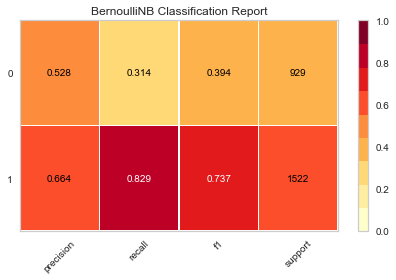

CART
0.6209710322317421
[[1522    0]
 [ 929    0]]


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


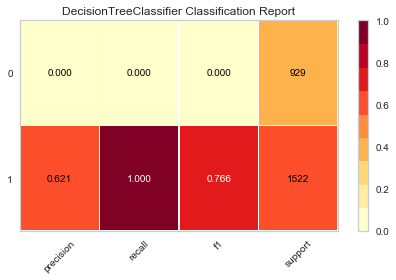

RFC
0.6960424316605467
[[1280  242]
 [ 503  426]]


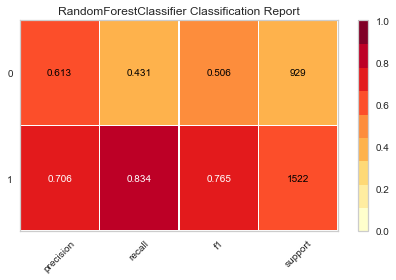

LDA
0.6744186046511628
[[1235  287]
 [ 511  418]]


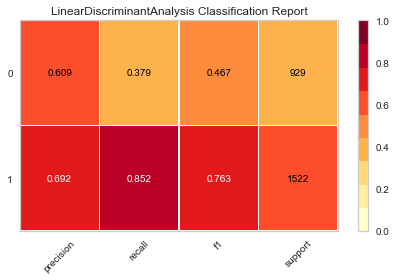

LRG
0.6695226438188494
[[1233  289]
 [ 521  408]]


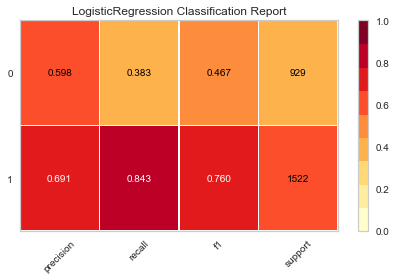

LCV
0.616891064871481
[[1423   99]
 [ 840   89]]


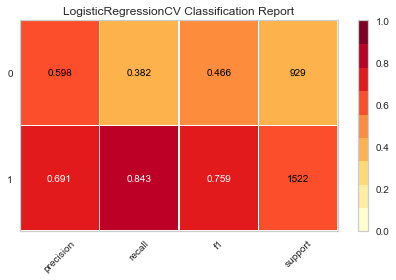

KNN
0.6328029375764994
[[1079  443]
 [ 457  472]]


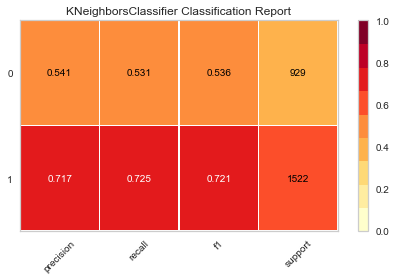

NCT
0.5854753161974704
[[934 588]
 [428 501]]


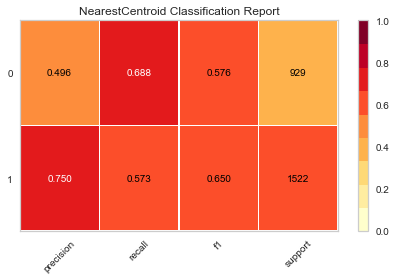

SVM
0.6221950224398205
[[1510   12]
 [ 914   15]]


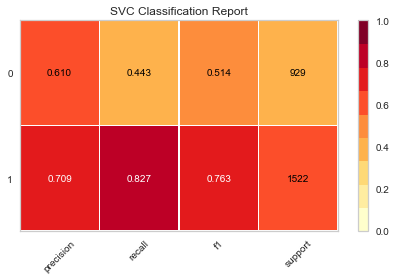

NuSVM
0.6189310485516116
[[1475   47]
 [ 887   42]]


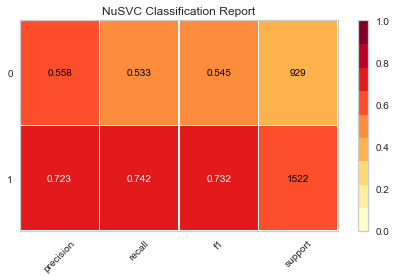

LinearSVC
0.4949000407996736
[[ 307 1215]
 [  23  906]]


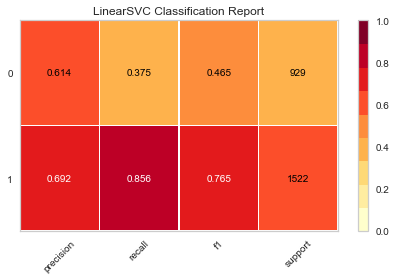

ABC
0.6723786209710322
[[1201  321]
 [ 482  447]]


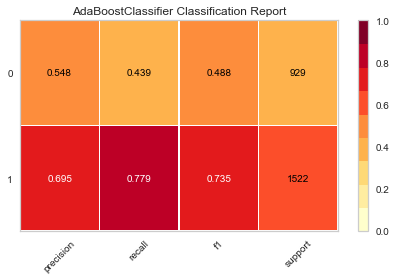

In [109]:
from yellowbrick.classifier import ClassificationReport
classes = ["IsTop40", "NoHit"]

def plotting(name, model):
    model.fit(X_train, Y_train)
    predictions = model.predict(X_validation)
    print(name)
    print(accuracy_score(Y_validation, predictions))
    print(confusion_matrix(Y_validation, predictions))
    pipe_mdl = make_pipeline(StandardScaler(),
                        PCA(n_components=18),
                        model)
    visualizer = ClassificationReport(pipe_mdl, classes=classes, support=True)
    visualizer.fit(X_train, Y_train)  # Fit the visualizer and the model
    visualizer.score(X_validation, Y_validation)  # Evaluate the model on the test data
    g = visualizer.poof()             # Draw/show/poof the data
    
for name, model in models:
    plotting(name, model)

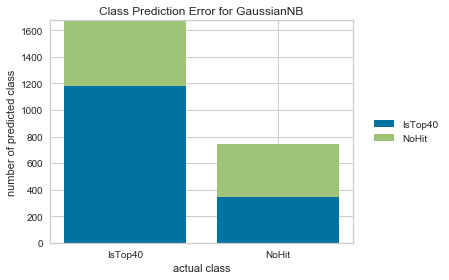

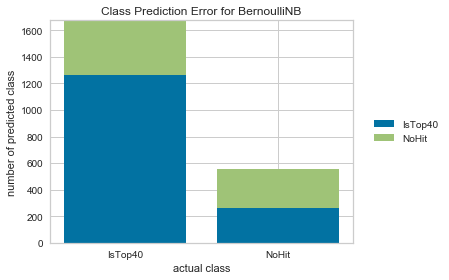

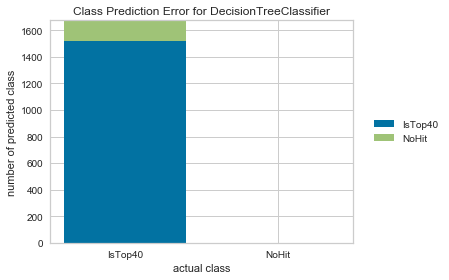

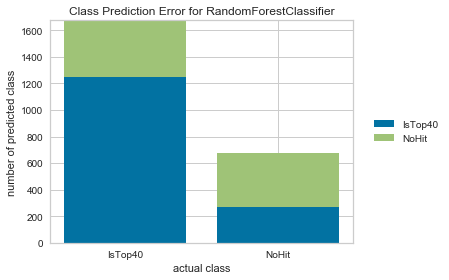

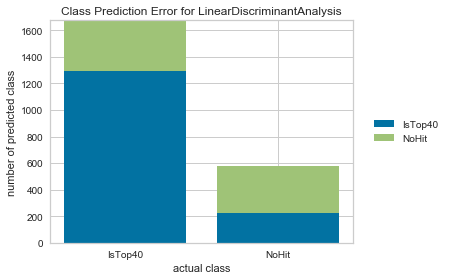

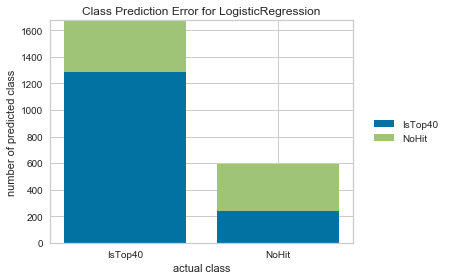

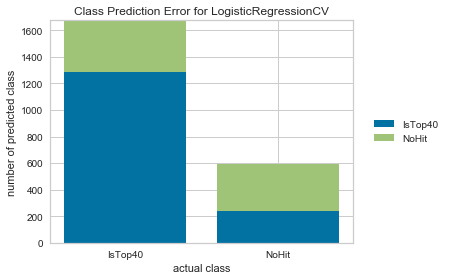

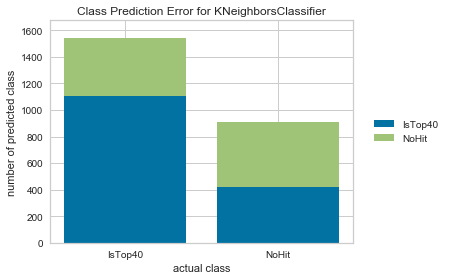

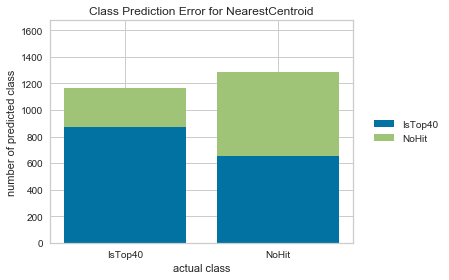

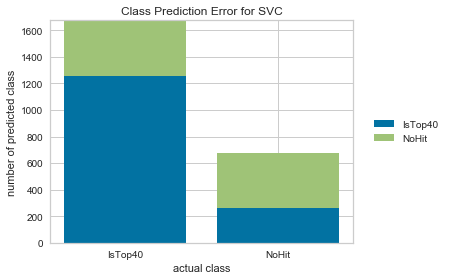

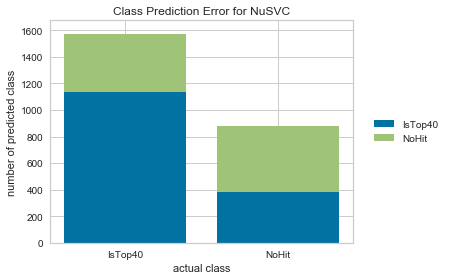

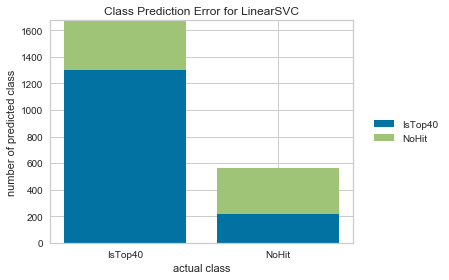

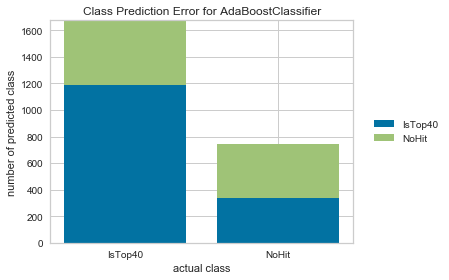

In [108]:
from sklearn.linear_model import Lasso
from yellowbrick.classifier import ClassPredictionError

def vizerror(name, model):
    # Instantiate the visualizer
    pipe_mdl = make_pipeline(StandardScaler(),
                        PCA(n_components=18),
                        model)
    visualizer = ClassPredictionError(
        pipe_mdl, classes=classes)
    # Fit
    visualizer.fit(X_train, Y_train)
    # Score and visualize
    visualizer.score(X_validation, Y_validation)
    visualizer.poof()
    
for name, model in models:
    vizerror(name, model)